<img src="glm-plot.png" width="400" height="400">

# GLM Deep Dive
## Frequency Severity modelling

This notebook is a deep dive into [General Linear Models (GLM's)](https://online.stat.psu.edu/stat504/node/216/) with a focus on the GLM's used in insurance risk modeling and pricing ([Yan, J. 2010)](https://www.casact.org/education/rpm/2012/handouts/Session_4738_presentation_1068_0.pdf).I have used GLM's before including: a Logistic Regression for landslide geo-hazards (([Postance, 2017](https://onlinelibrary.wiley.com/doi/full/10.1002/esp.4202))), for modeling extreme rainfall and developing catastrophe models ([Postance, 2017](https://scholar.google.co.uk/scholar?oi=bibs&cluster=13784644545966658880&btnI=1&hl=en)). The motivation for this post is to develop a deeper knowledge of the assumptions and application of the models and methods used by Insurance Actuaries, and to better understand how these compare to machine learning methods.

In [1]:
import urllib.request
import shutil
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
from patsy import dmatrices,dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Case study dataset: motorcylce insurance
The [Ohlsson dataset](https://cran.r-project.org/web/packages/insuranceData/insuranceData.pdf#Rfn.dataOhlsson.1) is from a former Swedish insurance company Wasa. The data includes aggregated  customer, policy and claims data for 64,548 motocycle coverages for the period 1994-1998. The data is used extensively in actuarial training and sylabus worldwide [Ohlsson, (2010)](https://www.springer.com/gp/book/9783642107900#aboutBook).


Variables inclde:
 1. (0:2) agarald - The owners age, between 0 and 99, a numeric vector.
 1. (2:3) kon - The owners sex,factor with levels K (female) M (male).
 1. (3:4) zon - Geographic zone numbered from 1 to 7, in a standard classification of all Swedish parishes, anumeric vector
 1. (4:5) mcklass - MC class, a classification by the so called EV ratio, defined as (Engine power in kW x100) / (Vehicle weight in kg + 75), rounded to the nearest lower integer. The 75 kg represents the average driver weight. The EV ratios are divided into seven classes, a numeric vector
 1. (5:7) fordald - Vehicle age, between 0 and 99, a numeric vector
 1. (7:8) bonuskl - Bonus class, taking values from 1 to 7. 
  - A new driver starts with bonus class 1. For each claim free year the bonus class is increased by 1. 
  - After the first claim the bonus is decreased by  2. The  driver  can  not  return  to  class  7  with  less  than  6  consecutive  claim  free  years,  a numeric vector
 1. (8:16) duration - the number of policy years, a numeric vector
 1. (16:20) antskad - the number of claims, a numeric vector
 1. (20:) skadkost - the claim cost, a numeric vector

- *(n:n) are the columnar positions of the data*
- *data avaliable [here](https://staff.math.su.se/esbj/GLMbook/case.html)*

In [2]:
# read or get file
file_name='mccase.txt'

try: 
    file = open(file_name,'r')
except:
    url = 'https://staff.math.su.se/esbj/GLMbook/mccase.txt'
    # Download the file from `url` and save it locally under `file_name`:
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    file = open(file_name,'r')

# load file
dat = list()
for line in file.readlines():
    dat.append([line[:2],line[2:3],line[3:4],line[4:5],line[5:7],line[7:8],line[8:16],line[16:20],str(line[20:]).replace('\n','')])
file.close()
df = pd.DataFrame(dat,columns=['Age','Sex','Geog','EV','VehAge','NCD','PYrs','Claims','Severity'])
df = df.astype({'Age':float,'Sex':'category','Geog':'category','EV':'category',
                'VehAge':int,'NCD':'category','PYrs':float,'Claims':int,'Severity':float}).copy()

# PYrs is the fraction of compelete policy years 
# there are some policies with 0.0 duration (1/365 = 0.00274 = 1 day)
# set these to 1 day
df.loc[df['PYrs']==0.0,'PYrs'] = 1.0/365.0

# single claim frequency indicator
df['Claim'] = (df['Claims']>=1).astype(int)

# avg severity
df['SeverityAvg'] = (df['Severity'] / df['Claims']).fillna(0.0)

pd.DataFrame({'dtype':df.dtypes,'null':df.isnull().sum(),'nunique':df.nunique()})

,dtype,null,nunique
Age,float64,0,85
Sex,category,0,2
Geog,category,0,7
EV,category,0,7
VehAge,int64,0,85
NCD,category,0,7
PYrs,float64,0,2577
Claims,int64,0,3
Severity,float64,0,590
Claim,int64,0,2


### EDA

- low number of claims and frequency (1% freq)

In [3]:
df.describe()

,Age,VehAge,PYrs,Claims,Severity,Claim,SeverityAvg
count,64548.000000,64548.000000,64548.000000,64548.000000,64548.000000,64548.000000,64548.000000
mean,42.416062,12.540063,1.010759,0.010798,264.017785,0.010380,246.964360
std,12.980960,9.727445,1.307356,0.107323,4694.693604,0.101352,4198.994975
min,0.000000,0.000000,0.002740,0.000000,0.000000,0.000000,0.000000
25%,31.000000,5.000000,0.463014,0.000000,0.000000,0.000000,0.000000
50%,44.000000,12.000000,0.827397,0.000000,0.000000,0.000000,0.000000
75%,52.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,92.000000,99.000000,31.339730,2.000000,365347.000000,1.000000,211254.000000


In [4]:
claims = df.loc[df['Claims']!=0]
claims.describe()

,Age,VehAge,PYrs,Claims,Severity,Claim,SeverityAvg
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.0,670.000000
mean,35.476119,7.965672,1.579415,1.040299,25435.552239,1.0,23792.620149
std,12.851056,6.768896,2.983317,0.196805,38539.415033,0.0,33765.250000
min,16.000000,0.000000,0.002740,1.000000,16.000000,1.0,16.000000
25%,25.000000,2.000000,0.430137,1.000000,3031.500000,1.0,3007.750000
50%,30.000000,7.000000,0.790411,1.000000,9015.000000,1.0,8723.500000
75%,47.000000,12.000000,1.497945,1.000000,29304.500000,1.0,26787.750000
max,68.000000,55.000000,31.167120,2.000000,365347.000000,1.0,211254.000000


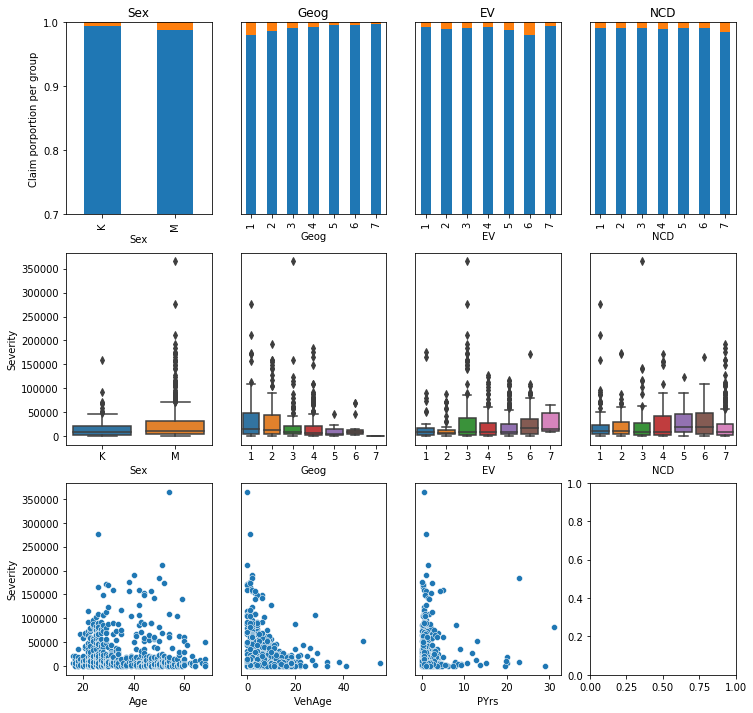

In [5]:
fig,axs=plt.subplots(3,4,figsize=(12,12),sharey=False)

# claim proportions by category
for ax,feat in zip(axs.flatten()[:4],df.select_dtypes(include='category').columns):
    ((pd.crosstab(df['Claim'],df[feat])) /
                    (pd.crosstab(df['Claim'],df[feat]).sum())).T.plot.bar(stacked=True,ax=ax,legend=False,title=None)
    ax.set_title(feat)
    ax.set_ylim(0.7,1)
    ax.set_yticks([])
axs[0,0].set_yticks(np.arange(0.7,1.0,0.1))
axs[0,0].set_ylabel('Claim porportion per group')

# severity by category
for col,ax in zip(df.select_dtypes(include='category').columns,axs.flatten()[4:]):
    sns.boxplot(x=col,y='Severity',data=claims,ax=ax)
    ax.set_yticks([])
    ax.set_ylabel('')

# severity by continuous
for col,ax in zip(['Age','VehAge','PYrs'],axs.flatten()[8:]):
    sns.scatterplot(x=col,y='Severity',data=claims,ax=ax)
    ax.set_yticks([])
    ax.set_ylabel('')

for ax in axs[1:3,0]:
    ax.set_ylabel('Severity')
    ax.set_yticks(np.arange(0,4e5,5e4))

### Modelling
- StatsModels (SM) uses patsy [formula notation](https://www.statsmodels.org/devel/example_formulas.html).
- This includes: [notation for categorical variables ](https://www.statsmodels.org/devel/contrasts.html), setting [reference/base levels](https://stackoverflow.com/a/22439820/4538066), [encoding options](https://www.statsmodels.org/devel/contrasts.html), and [operators](https://www.statsmodels.org/devel/example_formulas.html#categorical-variables).

In [6]:
# train-test splits stratifies on claims
# take copies to overcome chained assignment
train,test = train_test_split(df,test_size=0.3,random_state=1990,stratify=df['Claim'])
train = df.loc[train.index].copy()
test = df.loc[test.index].copy()
a,b,c,d = train['Claim'].sum(),train['Severity'].sum(),test['Claim'].sum(),test['Severity'].sum()
print(f"Frequency\nTrain:\t{len(train)}\t{a}\t${b}\nTest:\t{len(test)}\t{c}\t${d}\n")

# severity train test
train_severity = train.loc[train['Claim']>0].copy()
test_severity = test.loc[test['Claim']>0].copy()
a,b,c,d = train_severity['Claim'].sum(),train_severity['Severity'].sum(),test_severity['Claim'].sum(),test_severity['Severity'].sum()
print(f"Severity\nTrain:\t{len(train_severity)}\t{a}\t${b}\nTest:\t{len(test_severity)}\t{c}\t${d}\n")

Frequency
Train:	45183	469	$11664342.0
Test:	19365	201	$5377478.0

Severity
Train:	469	469	$11664342.0
Test:	201	201	$5377478.0



### $Claim Frequency$

For predicting the occurence of a single claim (i.e. binary classification) one can use the Binomial distribution (a.k.a Bernoulli trial or coin-toss experiment).

When predicting claim counts or frequency, $Y$, a model that prodices Poisson distributed outputs is required. For instance, a Poisson model is suitable for estimating the number of insurance claims per policy per year, or to estimate the number of car crashes per month. 

The key components and assumptions of a Poisson distributed process are: 
 1. event occurence is independant of other events. 
 1. events occur within a fixed period of time.
 1. the mean a variance of the distribution are equal e.g. $mu(X) = Var(X) = λ$
 
[*STAT 504: Poisson Distribution*](https://online.stat.psu.edu/stat504/node/57/)


If the mean and variance are unequal the distribution is said to be over-disperesed (var > mean) or under-dispersed (var < mean). Over-dispersion commonly arises in data where there are large number of zero's (a.k.a [zero-inflated](https://en.wikipedia.org/wiki/Zero-inflated_model)).

In the case of zero-inflated data, it is "*A sound practice is to estimate both Poisson and negative binomial models.*" [*Cameron, 2013*](http://faculty.econ.ucdavis.edu/faculty/cameron/racd2/). Also see this practical example for [beverage consumption in pdummy_xyhon](https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/)

In GLM's, link-functions are applied in order to make the mean outcome (prediction) fit to some linear model of input variables from other distributions. "*A natural fit for count variables that follow the Poisson or negative binomial distribution is the log link. The log link exponentiates the linear predictors. It does not log transform the outcome variable.*" - [*Count Models: Understanding the Log Link Function,TAF*](https://www.theanalysisfactor.com/count-models-understanding-the-log-link-function/)

For more information on link-functions see also [here](https://bookdown.org/castillo_sam_d/Exam-PA-Study-Manual/glms-for-classification.html#link-functions).

![link functions](https://i0.wp.com/www.theanalysisfactor.com/wp-content/uploads/2016/12/StataCombos-CM2-Blog-JM.png?w=535&ssl=1)

Lastly, for any form of count prediction model one can also set an offset or exposure. 

An offset, if it is known, is applied in order to account for the relative differences in exposure time for of a set of inputs. For example, in insurance claims we might expect to see more claims on an account with 20 years worth of annual policies compared to an account with a single policy year. Offsets account for the relative exposure|surface area|population size|etc and is akin to the relative frequency of occurence ($Claims/years$). See these intuititve SO answers [here](https://stats.stackexchange.com/questions/232666/should-i-use-an-offset-for-my-poisson-glm), [here](https://github.com/statsmodels/statsmodels/issues/1486#issuecomment-40945831), and [here](https://stats.stackexchange.com/questions/25415/using-offset-in-binomial-model-to-account-for-increased-numbers-of-patients).

In [7]:
# Mean & Variance
mu = df.Claims.mean()
var = np.mean([abs(x - mu)**2 for x in df.Claims])
print(f'mu =  {mu:.4f}\nvar = {var:.4f}')

mu =  0.0108
var = 0.0115


Here we observe an over-dispersed zero-inflated case as the variance of claim occurence ($v=0.0115$) exceeds its mean ($mu=0.0108$).

As suggested in Cameron (2013) we should therefore try both $Poisson$ and $Negative Binomial$ distributions.

For good measure, and to illustrate its relationship, lets also include a $Binomial$ distribution model. The Binomial model with a logit link is equivalent to a binary Logistic Regression model [[a](https://www.researchgate.net/post/what_is_the_difference_between_running_a_binary_logistic_regression_and_generalised_linear_model),[b](https://towardsdatascience.com/the-binomial-regression-model-everything-you-need-to-know-5216f1a483d3)]. Modelling A binary outcome is not a totally unreasonable approach in this case given that the number of accounts with claims $n>1$ is low (22) and as the $Binomial$ distribution extends to a $Poisson$ when trials $N>20$ is high and $p<0.05$ is low (see [wiki](https://en.wikipedia.org/wiki/Poisson_distribution#Related_distributions), [here](https://math.stackexchange.com/questions/1050184/difference-between-poisson-and-binomial-distributions) and [here](https://www.itl.nist.gov/div898/handbook/pmc/section3/pmc331.htm)).

However, there is one change we need to make with the Binomial model. That is to alter the way we handle exposure. A few hours of research on the matter led me down the rabbit hole of conflicting ideas in textbooks, papers [[i](https://doi.org/10.1093/ije/dyu029)] and debates on CrossValidated [[a](https://stats.stackexchange.com/questions/246318/difference-between-offset-and-weights),[b](https://stats.stackexchange.com/questions/25415/using-offset-in-binomial-model-to-account-for-increased-numbers-of-patients/35478)]. In contrast to poisson and neg binomial there is no way to add a constant term or offset in the binomial formulation [(see here)](https://stats.stackexchange.com/a/35478/100439). Rather it is appropriate to either: [include the exposure as a predictor variable](https://stats.stackexchange.com/a/35436/100439), or to use weights for each observation (see [here](https://stackoverflow.com/a/62798889/4538066) and the [statsmodels guidance on methods for GLM with weights and observed freqeuncies](https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM). I opted for the weighted GLM. The model output of the binomial GLM is the probability of at least 1 claim occuring weighted by the observation time $t=Pyrs$. Note there is no equivalent setting on the predict side, the predictions assume a discrete equivalent time exposure t=1.

In addition it is common in insurance risk models to use a [quasi-poisson or zero inflated poisson (ZIP)](https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057) model in scenarios with high instances of zero claims. In data science and machine learning we would refer to this as an unbalanced learning problem (see bootstrap, cross validation, SMOTE). The ZIP model combines:
 - a binomial model to determine the likelihood of one or more claims occuring (0/1)
 - a negative binomial or poisson to estimate the number of claims (0...n)
 - a severity model to estimate the avg size of each claim (1...n)

In [8]:
# # examples of formula notation in smf
# print(' + '.join(train.columns))
# expr = "Claims ~ Age+C(Sex)+C(Geog, Treatment(reference=3))+EV+VehAge+NCD"

# including PYrs as parameter commented out in glm()
expr = "Claims ~ Age + Sex + Geog + EV + VehAge + NCD" # + np.log(PYrs)

FreqPoisson = smf.glm(formula=expr,
                      data=train,
                      offset=np.log(train['PYrs']),
                      family=sm.families.Poisson(link=sm.families.links.log())).fit()

FreqNegBin = smf.glm(formula=expr,
                      data=train,
                      offset=np.log(train['PYrs']),
                      family=sm.families.NegativeBinomial(link=sm.families.links.log())).fit()

# uses the binary "Claim" field as target
# offset is Pyrs (Years complete 0.0...n)
# aka similar to binary logistic regression
FreqBinom = smf.glm(formula="Claim ~ Age + Sex + Geog + EV + VehAge + NCD " ,
                    data=train,
                    freq_weights=train['PYrs'],
                    family=sm.families.Binomial(link=sm.families.links.logit())).fit()

### Model coefficients

***Poisson Parameters***
- [Poisson GLM params](https://stackoverflow.com/questions/14923684/interpreting-the-output-of-glm-for-poisson-regression)
- [Find lambda](https://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram)

We can derive the model output using predict or the raw coefficients. Sampling the poisson rate ($lambda$) illustrates the difference in predicted rates for the intercept and for a when a driver is male. 

In [9]:
FreqPoisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Claims   No. Observations:                45183
Model:                            GLM   Df Residuals:                    45161
Model Family:                 Poisson   Df Model:                           21
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2541.7
Date:                Sun, 18 Oct 2020   Deviance:                       4135.6
Time:                        11:33:43   Pearson chi2:                 1.83e+05
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9052      0.284     -3.184      0.001      -1.462      -0.348
Sex[T.M]       0.3881      0.162      2.392      0.017       0.070       0.706
Geog[T.2]     -0.6478      0.135     -4.811      0.000      -0.912      -0.384
Geog[T.3]     -0.9043      0.137     -6.606      0.000      -1.173      -0.636
Geog[T.4]     -1.3826      0.123    -11.254      0.000      -1.623      -1.142
Geog[T.5]     -1.5218      0.389     -3.912      0.000      -2.284      -0.759
Geog[T.6]     -1.4581      0.315     -4.623      0.000      -2.076      -0.840
Geog[T.7]    -22.0308   1.77e+04     -0.001      0.999   -3.47e+04    3.46e+04
EV[T.2]        0.0923      0.237      0.389      0.697      -0.372       0.557
EV[T.3]       -0.4219      0.199     -2.115      0.034      -0.813      -0.031
EV[T.4]       -0.3602      0.215     -1.678      0.093      -0.781       0.061
EV[T.5]       -0.0334      0.204     -0.164      0.870      -0.433       0.367
EV[T.6]        0.4132      0.202      2.042      0.041       0.017       0.810
EV[T.7]        0.3316      0.483      0.687      0.492      -0.614       1.278
NCD[T.2]      -0.1441      0.181     -0.795      0.426      -0.499       0.211
NCD[T.3]       0.0184      0.192      0.096      0.923      -0.357       0.394
NCD[T.4]       0.3047      0.184      1.660      0.097      -0.055       0.664
NCD[T.5]      -0.0535      0.215     -0.249      0.804      -0.475       0.368
NCD[T.6]       0.0967      0.206      0.470      0.639      -0.307       0.501
NCD[T.7]       0.1835      0.137      1.334      0.182      -0.086       0.453
Age           -0.0580      0.004    -13.633      0.000      -0.066      -0.050
VehAge        -0.0762      0.008     -9.781      0.000      -0.091      -0.061
==============================================================================
"""

Lambda intercept: 0.40
Lambda intercept + male: 0.60


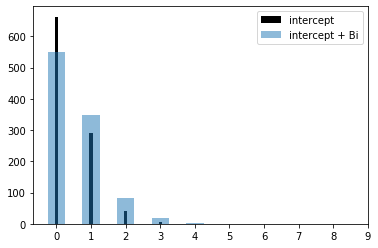

In [10]:
fig,axs = plt.subplots(1,1)

bins = np.arange(0,10,1)
n = 1000
print(f'Lambda intercept: {np.exp(FreqPoisson.params[0]):.2f}\nLambda intercept + male: {np.exp(FreqPoisson.params[0]+FreqPoisson.params[1]):.2f}')

axs.hist(np.random.poisson(lam=np.exp(FreqPoisson.params[0]),size=n),
         bins=bins,rwidth=0.1,
         alpha=1,label='intercept', align='left',color='k')

axs.hist(np.random.poisson(lam=np.exp(FreqPoisson.params[0]+FreqPoisson.params[1]),size=n),
         bins=bins,rwidth=0.5,
         alpha=0.5,label='intercept + Bi',align='left')
axs.set_xticks(bins)
axs.legend();

In [11]:
# get prediction to access easy confidence intervals
gp = FreqPoisson.get_prediction(test)
gp.summary_frame(alpha=0.05)[:2]

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.036901,0.007723,0.024485,0.055614
1,0.030348,0.006528,0.019908,0.046263


***Negative binomial coefficients and incidence rate ratio***

 - https://stats.idre.ucla.edu/stata/dae/negative-binomial-regression/
 - https://stats.stackexchange.com/questions/17006/interpretation-of-incidence-rate-ratios
 - https://stats.stackexchange.com/questions/414752/how-to-interpret-incidence-rate-ratio
 - https://www.cdc.gov/csels/dsepd/ss1978/lesson3/section5.html

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                45183
Model:                            GLM   Df Residuals:                    45161
Model Family:        NegativeBinomial   Df Model:                           21
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2535.9
Date:                Sun, 18 Oct 2020   Deviance:                       3754.7
Time:                        11:33:43   Pearson chi2:                 1.82e+05
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8851      0.288     -3.069      0.0

/home/ben/anaconda3/envs/machine-learning/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


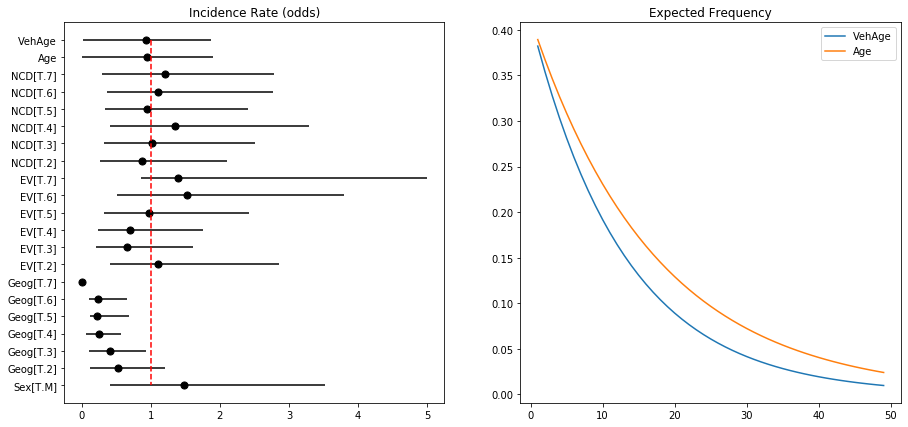

In [12]:
print(FreqNegBin.summary())
X_ = np.arange(0,len(FreqNegBin.params[1:]))
irr_ = np.exp(FreqNegBin.params[1:])
frq_ = [np.exp(FreqNegBin.params[0]+x) for x in FreqNegBin.params[1:]]
df_ = pd.DataFrame({'X':X_,'irr':irr_,'frq':frq_})
df_['lwr'] = np.exp(FreqNegBin.conf_int()[0])
df_['upr'] = np.exp(FreqNegBin.conf_int()[1])

fig,axs = plt.subplots(1,2,figsize=(15,7))
ages_ = np.arange(1,50,1)

axs[0].set_title('Incidence Rate (odds)')
axs[0].scatter(x=df_.irr,y=df_.X,s=50,c='k',linestyle='None')
axs[0].errorbar(x=df_.irr,y=df_.X,xerr=(df_.lwr,df_.upr),c='k',linestyle='None')
axs[0].plot([1,1],[20,0],'r--')
axs[0].set_yticks(df_.X)
axs[0].set_yticklabels(irr_.index)

axs[1].set_title('Expected Frequency')
axs[1].plot(ages_,[np.exp(FreqNegBin.params[0]+FreqNegBin.params['VehAge']*i) for i in ages_],label='VehAge')
axs[1].plot(ages_,[np.exp(FreqNegBin.params[0]+FreqNegBin.params['Age']*i) for i in ages_],label='Age')
axs[1].legend();

***Binomial Model Coefficients and Logits Log-Odds, Odds and Probabilties***
- https://sebastiansauer.github.io/convert_logit2prob/

In [13]:
print(FreqBinom.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Claim   No. Observations:                45183
Model:                            GLM   Df Residuals:                 45690.29
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3504.3
Date:                Sun, 18 Oct 2020   Deviance:                       7008.7
Time:                        11:33:44   Pearson chi2:                 4.72e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7911      0.289     -9.672      0.0

In [14]:
# Example conversions from logits to probabilities
const = FreqBinom.params[0]
odds = np.exp(const)
probability = odds / (1+odds)
print(f'Intercept: p = {probability:.3f}')
_ = np.exp(const+FreqBinom.params[1])/(1+(np.exp(const+FreqBinom.params[1])))
print(f'Intercept + Male: p = {_:.3f} ({_-probability:.3f})')

Intercept: p = 0.058
Intercept + Male: p = 0.114 (0.056)


/home/ben/anaconda3/envs/machine-learning/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/ben/anaconda3/envs/machine-learning/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


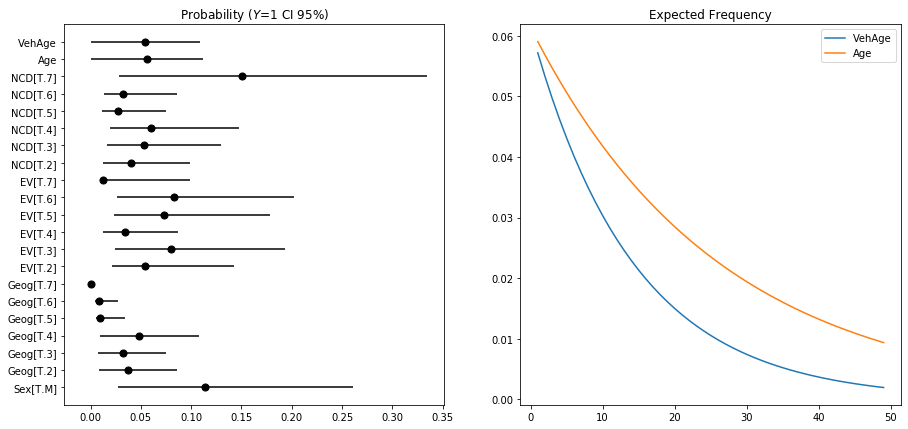

In [15]:
X_ = np.arange(0,len(FreqBinom.params[1:]))
odds = np.exp(FreqBinom.params[1:])
frq_ = [np.exp(FreqBinom.params[0]+x)/(1+np.exp(FreqBinom.params[0]+x)) for x in FreqBinom.params[1:]]
df_ = pd.DataFrame({'X':X_,'irr':irr_,'frq':frq_})
df_['lwr'] = [np.exp(FreqBinom.params[0]+x)/(1+np.exp(FreqBinom.params[0]+x)) for x in FreqBinom.conf_int()[0][1:]]
df_['upr'] = [np.exp(FreqBinom.params[0]+x)/(1+np.exp(FreqBinom.params[0]+x)) for x in FreqBinom.conf_int()[1][1:]]

fig,axs = plt.subplots(1,2,figsize=(15,7))
ages_ = np.arange(1,50,1)

axs[0].set_title('Probability ($Y$=1 CI 95%)')
axs[0].scatter(x=df_.frq,y=df_.X,s=50,c='k',linestyle='None')
axs[0].errorbar(x=df_.frq,y=df_.X,xerr=(df_.lwr,df_.upr),c='k',linestyle='None')
axs[0].set_yticks(df_.X)
axs[0].set_yticklabels(irr_.index)

axs[1].set_title('Expected Frequency')
axs[1].plot(ages_,[np.exp(FreqBinom.params[0]+FreqBinom.params['VehAge']*i) for i in ages_],label='VehAge')
axs[1].plot(ages_,[np.exp(FreqBinom.params[0]+FreqBinom.params['Age']*i) for i in ages_],label='Age')
axs[1].legend();

### Prediction

,Age,Sex,Geog,EV,VehAge,NCD,PYrs,Claims,Severity,Claim,SeverityAvg,Fnb,Fpo,Fbi
48748,52.0,M,3,4,15,7,1.000000,0,0.0,0,0.0,0.003172,0.003167,0.005506
43433,49.0,M,4,4,11,1,1.479452,0,0.0,0,0.0,0.003901,0.003902,0.004308
59148,60.0,M,3,2,16,3,0.501370,0,0.0,0,0.0,0.001240,0.001234,0.001946
37661,46.0,M,5,3,20,4,0.391781,0,0.0,0,0.0,0.000669,0.000687,0.001194
62202,65.0,M,2,3,6,3,0.495890,0,0.0,0,0.0,0.001498,0.001512,0.005599


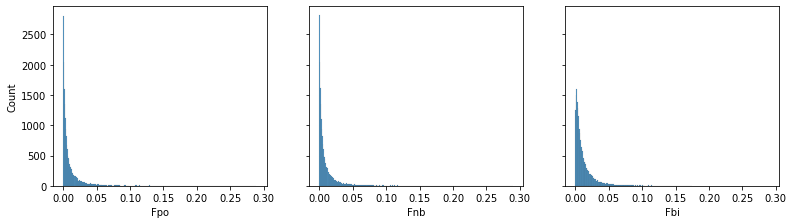

In [16]:
test['Fnb'] = FreqNegBin.predict(transform=True,exog=test,offset=np.log(test['PYrs']))
test['Fpo'] = FreqPoisson.predict(transform=True,exog=test,offset=np.log(test['PYrs']))
test['Fbi'] = FreqBinom.predict(transform=True,exog=test)

fig,axs = plt.subplots(1,3,figsize=(13,3.3),sharex=True,sharey=True)
sns.histplot(test['Fpo'],ax=axs[0],label='Poisson')
sns.histplot(test['Fnb'],ax=axs[1],label='NegBinomial')
sns.histplot(test['Fbi'],ax=axs[2],label='Binomial')

test.sample(5)

Loooking at the model summaries, the histograms and results the of predicted values on the test, we see that each model weights covariates similarly and produces similar scores on the test data. ***Again note*** that the $Binomial$ model was only used to demonstrate its similarity in this case, but this may not hold for other data.

### $Claim Severity$




In [17]:
# including PYrs as parameter commented out in glm()
expr = "SeverityAvg ~ Age + Sex + Geog + EV + VehAge + NCD"

### Estimate severity using GLM-gamma with default inverse-power link
SevGamma = smf.glm(formula=expr,
              data=train_severity,
              family=sm.families.Gamma(link=sm.families.links.inverse_power())).fit()

/home/ben/anaconda3/envs/machine-learning/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


Ignore the warning for now we will come back to that.

After fitting a GLM-Gamma, how do we find the Gamma shape ($a$) and scale ($b$) params of predictions for $Xi$?

"*Regression with the gamma model is going to use input variables Xi and coefficients to make a pre-diction about the mean of yi, but in actuality we are really focused on the scale parameter βi.  This is so because we assume that αi is the same for all observations, and so variation from case to case in μi=βiα is due simply to variation in βi.*" [technical overview of gamma glm](https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf)

- [gamma handout](https://pj.freefaculty.org/guides/stat/Distributions/DistributionWriteups/Gamma/Gamma-02.pdf)
- [Gamma Choice of link function](http://people.stat.sfu.ca/~raltman/stat402/402L26.pdf)
- [exmaple finding scale in R](https://stat.ethz.ch/pipermail/r-help/2011-July/283736.html)
- [generalized linear model - Dispersion parameter for Gamma family - Cross Validated](https://stats.stackexchange.com/questions/247624/dispersion-parameter-for-gamma-family)
- [Pdummy_xyhon: Calculating scale/dispersion of Gamma GLM using statsmodels](https://stackoverflow.com/questions/60215085/calculating-scale-dispersion-of-gamma-glm-using-statsmodels)

[Alternatively you can infer gamma parameters from CI](https://math.stackexchange.com/questions/2873763/is-it-possible-to-determine-shape-and-scale-for-a-gamma-distribution-from-a-mean?newreg=d61b4517cd304ecca335b8e69220bf0c)
- [gamma.shape.glm: Estimate the Shape Parameter of the Gamma Distribution R MASS](https://rdrr.io/cran/MASS/man/gamma.shape.glm.html)
- [The identity link function does not respect the domain of the Gamma family? - Cross Validated](https://stats.stackexchange.com/questions/356053/the-identity-link-function-does-not-respect-the-domain-of-the-gamma-family)

Below I illustrate the range of predicted severity values for the intercept and each level in Geogrpahy.

Shape: 0.54
Intercept: 52203


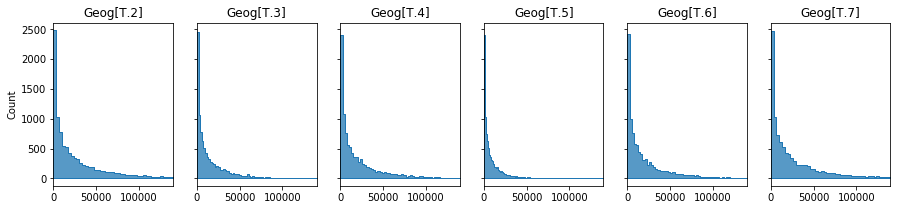

In [18]:
# shape is
shape = 1/SevGamma.scale
print(f'Shape: {shape:.2f}')

# intercept 
constant,intercept = SevGamma.params[0],SevGamma.scale/SevGamma.params[0]
print(f'Intercept: {intercept:.0f}')

# predicted mean G(Yi) is exp(Bo + Bi*Xi..)
geogs = [(i,SevGamma.scale/(constant+c)) for i,c in zip(SevGamma.params.index,SevGamma.params) if 'Geog' in i]

# plot
fig,axs = plt.subplots(1,6,sharex=True,sharey=True,figsize=(15,3))
for ax,x in zip(axs.flatten(),geogs):
    sns.histplot(np.random.gamma(shape=shape,scale=x[1],size=10000),stat="count",element="step",ax=ax,)
    ax.set_title(x[0])
    ax.set_xlim(0,14e4)

So remember the GLM-Gamma model gives us a prediction of the average severity of a claim should one occur.

In [19]:
test_severity['Giv'] = SevGamma.predict(transform=True,exog=test_severity)
test_severity[:3]

,Age,Sex,Geog,EV,VehAge,NCD,PYrs,Claims,Severity,Claim,SeverityAvg,Giv
35445,45.0,M,4,6,2,7,4.920548,1,2480.0,1,2480.0,28728.757724
9653,26.0,M,6,6,9,5,0.589041,1,46000.0,1,46000.0,21782.480267
2039,21.0,M,2,2,19,1,0.432877,1,11110.0,1,11110.0,11537.649676


Now, remember the error we got using the inverse-power link function. The warning is fairly self explanatory "the inverse_power link function does not respect the domain of the Gamma family". Oddly this is a design feature of Statsmodels at the [time of writing](https://github.com/statsmodels/statsmodels/issues/3316#issuecomment-266453597). Rather it is better to use the log link function to ensure all predicted values are > 0.

***GLM-Gamma log link***

- https://pj.freefaculty.org/guides/stat/Distributions/DistributionWriteups/Gamma/Gamma-02.pdf
- https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf
- http://people.stat.sfu.ca/~raltman/stat402/402L26.pdf
- https://stats.stackexchange.com/questions/431120/how-to-interpret-parameters-of-glm-output-with-gamma-log-link
- https://seananderson.ca/2014/04/08/gamma-glms/


In [20]:
# formula
expr = "SeverityAvg ~ Age + Sex + Geog + EV + VehAge + NCD"

### Estimate severity using GLM-gamma with default log link
SevGamma = smf.glm(formula=expr,
                   data=train_severity,
                   family=sm.families.Gamma(link=sm.families.links.log())).fit()

Dispersion: 2.0528
Shape: 0.4872
Intercept: 69330.81


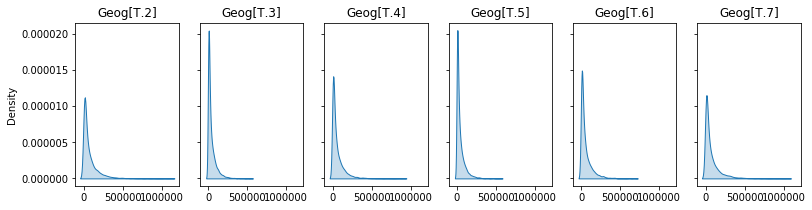

In [21]:
# dispersion aka rate
dispersion = SevGamma.scale
print(f'Dispersion: {dispersion:.4f}')

# shape is 1/dispersion
shape = 1/dispersion
print(f'Shape: {shape:.4f}')

# intercept
constant,intercept = SevGamma.params[0],np.exp(SevGamma.params[0])
print(f'Intercept: {intercept:.2f}')

# predicted mean G(Yi) is exp(Bo + Bi*Xi..)
# tuple(name,Yi,scale)
geogs = [(i,
          np.exp(constant+c),
          np.exp(constant+c)*dispersion)
         for i,c in zip(SevGamma.params.index,SevGamma.params) if 'Geog' in i]

# plot
fig,axs = plt.subplots(1,6,sharex=True,sharey=True,figsize=(13,3))

for ax,x in zip(axs.flatten(),geogs):
    sns.kdeplot(np.random.gamma(shape=shape,scale=x[2],size=10000),shade=True,ax=ax,)
    ax.set_title(x[0])

Statsmodels uses patsy design matrices behind the scenes. We can apply the design matrix to calculate the distribution parameters for both the frequency and severity models, and for any data set. Train, test, synthetic data and portfolios. You name it.

This is an incredibly powerfull approach as it enables the development of highly parameterised Monte Carlo and risk simulation models.I will walk the steps using pandas dataframes so that it is clear:

In [22]:
# 1. Define a dummy model for your data and using the same formula and settings defined earlier.
dummy_ = smf.glm(formula=expr,data=test_severity,family=sm.families.Gamma(link=sm.families.links.log()))

# 2. we can then access the desing matrix. 
# Which is simply the data values, but also handling the intercept and reference categories.
a = pd.DataFrame(dummy_.data.exog,columns=dummy_.data.param_names)

# 3. Retrieve and transpose the trained model coefficients
b = pd.DataFrame(SevGamma.params).T

# 4. And multiply together
# but this only works if indexes are equal
c = a.multiply(b,axis=0)

# 5. It is much cleaner to use arrays. 
# et voila
c = pd.DataFrame(dummy_.data.exog * SevGamma.params.values,columns=dummy_.data.param_names)
c.shape

(201, 22)

We can then use the coefficients to estimate and plot the values and samples of each row, or the entire dataset.

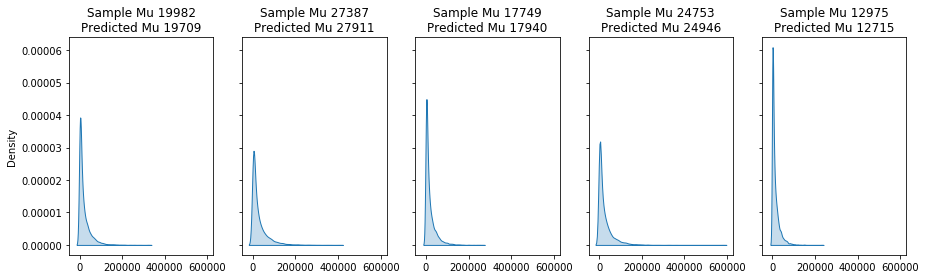

In [23]:
dispersion = SevGamma.scale
shape = 1/dispersion

num=5
fig,axs = plt.subplots(1,num,figsize=(15,4),sharex=True,sharey=True)

for i,pred,ax in zip(c.index[:num],SevGamma.predict(test_severity)[:num],axs.flatten()):
    scale = np.exp(c.loc[[i]].sum(axis=1))*dispersion
    sample = np.random.gamma(shape=shape,scale=scale,size=10000)
    sns.kdeplot(sample,label=i,ax=ax,shade=True)
    ax.set_title(f'Sample Mu {sample.mean():.0f}\nPredicted Mu {pred:.0f}',fontsize=12)

Here are some other ways you can work with GLM gamma coefficients

In [24]:
# mean severity in train
print(train_severity['SeverityAvg'].mean())

# intercept severity
print(np.exp(SevGamma.params[0]))

# Xi severity 
print(np.exp(SevGamma.params[0]+SevGamma.params[1]))

# Xi abs difference to intercept
print(np.exp(SevGamma.params[0]+SevGamma.params[1]) - np.exp(SevGamma.params[0]) )

# % of intercept
print(np.exp(SevGamma.params[1]))

# % change from intercept
print(np.exp(SevGamma.params[1])-1.0)

# Xi severity by multiplication
print(np.exp(SevGamma.params[0])*np.exp(SevGamma.params[1]))

23721.149253731342
69330.81029226439
58091.82125707675
-11238.989035187638
0.8378932975424691
-0.1621067024575309
58091.821257076765


# Putting it all together: Frequency-Severity model

***Recap on probabilities***
- [p of x in n years](https://math.stackexchange.com/a/490890/775441)

In [25]:
# p of no claim per year
print('p0 yr:', 1.0-FreqBinom.predict(test)[:3].values)

# p of 1+ claim per year
print('p1 yr:',FreqBinom.predict(test)[:3].values)

# p of no claim for 10 years
print('p0 10yr:',(1.0-FreqBinom.predict(test)[:3].values)**10)

# est likelihood of 1+ claim in 10 years
print('p1 10yr:',1 - (1.0 - FreqBinom.predict(test)[:3].values)**10)

# avg claim size of known claims
print((test_severity['SeverityAvg']/1000).mean())

# avg predicted claim size
print((SevGamma.predict(test_severity)/1000).mean())

p0 yr: [0.99003109 0.98619889 0.98386389]
p1 yr: [0.00996891 0.01380111 0.01613611]
p0 10yr: [0.90466613 0.87025215 0.84986556]
p1 10yr: [0.09533387 0.12974785 0.15013444]
23.9593855721393
24.38600603349808


***Portfolio price***

Given that this is motor insurance, lets assume a thin margin for %0.05

In [26]:
# make a dummy portfolio and make predictions
portfolio = test.reset_index(drop=True).copy()
portfolio['annual_frq'] = FreqBinom.predict(portfolio)
portfolio['expected_sev'] = SevGamma.predict(portfolio)

# expected annual loss
portfolio['annual_exp_loss'] = portfolio['annual_frq'] * portfolio['expected_sev']

# set pricing ratio
tolerable_loss = 0.05
pricing_ratio = 1.0-tolerable_loss
portfolio['annual_tech_premium'] = portfolio['annual_exp_loss']/pricing_ratio
portfolio['result'] = portfolio['annual_tech_premium'] - portfolio['Severity']
portfolio.iloc[:3,-4:]

,expected_sev,annual_exp_loss,annual_tech_premium,result
0,27818.169806,277.316838,291.912461,291.912461
1,21753.203517,300.218299,316.019262,316.019262
2,18524.970346,298.920877,314.653555,314.653555


This summary illustrates the:
- observed Claims and Losses (Severity)
- the predicted frq, losses, and expected-losses
- the technical premium
- the profit loss result (calculated on full Severity rather than SeverityAvg)

In [27]:
pd.DataFrame(portfolio[['Claim', 'Severity',
                        'annual_frq','expected_sev', 'annual_exp_loss',
                        'annual_tech_premium','result']].sum(),
             columns=['Summary']).T

,Claim,Severity,annual_frq,expected_sev,annual_exp_loss,annual_tech_premium,result
Summary,201.0,5377478.0,249.038867,4.054346e+08,5.764319e+06,6.067705e+06,690226.503245


No we can build a Monte Carlo simulation to:
- provide a more robust estimate of our expected profit / loss
- sample the parameter space to gauge the variance and uncertainty in our model and assumptions
- calculate metrics for the AAL, AEP, and AXS loss and return

In [28]:
# fitted params
dispersion = SevGamma.scale
shape = 1/dispersion
# define a dummy model to get the get design matrix
dummy_ = smf.glm(formula=expr,data=portfolio,family=sm.families.Gamma(link=sm.families.links.log()))
dmtrx = pd.DataFrame(dummy_.data.exog,columns=dummy_.data.param_names)
# calculate scale for each row
scales_ = pd.DataFrame(dmtrx * SevGamma.params.values,columns=dummy_.data.param_names)
scales_ = np.exp(scales_.sum(axis=1))*dispersion
portfolio['gamma_shape'] = shape
portfolio['gamma_scale'] = scales_

In [29]:
# simulate portfolio
simulation = dict()
frq = list()
sev = list()
N=999

for it in range(N):
    print(f"{it}/{N}",end='\r')

    frq.append(np.random.binomial(n=1,p=portfolio['annual_frq']))
    sev.append(np.random.gamma(shape=portfolio['gamma_shape'],scale=portfolio['gamma_scale']))

# calculate Frq * Sev
frq_sev = np.array(frq)*np.array(sev)
# summarise the simulations
simulation['sim'] = pd.DataFrame({'iteration':range(N),
                                  'claim_num':np.array(frq).sum(axis=1),# num claims
                                  'loss_min':np.array(frq_sev).min(axis=1), # min claim
                                  'loss_sum':np.array(frq_sev).sum(axis=1), # total
                                  'loss_max':np.array(frq_sev).max(axis=1), # max claim
                                  'loss_avg':np.array(frq_sev).mean(axis=1)
                              })

Calculate the Annual Exceedence Probability

- https://sciencing.com/calculate-exceedance-probability-5365868.html
- https://serc.carleton.edu/quantskills/methods/quantlit/RInt.html
- https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/floods-return-period-and-probability/

In [30]:
def exceedance_prob(df,feature,ascending=False):
    data = df.copy()
    data['value'] = data[feature]
    data[f'Rank'] = data['value'].rank(ascending=ascending,method='dense')
    data[f'RI'] = (len(data)+1.0)/data[f'Rank']
    data[f'EP'] = 1.0/data[f'RI']
    data.sort_values([f'value'],ascending=ascending,inplace=True)
    data.reset_index(drop=True,inplace=True)
    return data

In [31]:
# profit loss based on technical premium
simulation['sim']['technical_premium'] = portfolio['annual_tech_premium'].sum()
simulation['sim']['result'] = (simulation['sim']['technical_premium'] - simulation['sim']['loss_sum'])

# recurrence intervals of each measure
simulation['loss_sum'] = exceedance_prob(simulation['sim'],'loss_sum')
simulation['loss_max'] = exceedance_prob(simulation['sim'],'loss_max')
simulation['result'] = exceedance_prob(simulation['sim'],'result',ascending=True)

This illustrates the profit and loss scenarios for our pricing strategy across $N$ iterations.

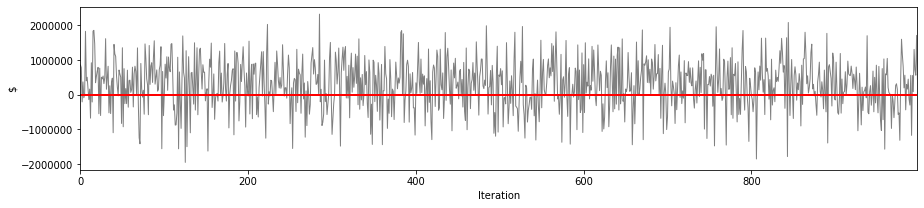

In [32]:
simulation['sim']['result'].plot(figsize=(15,3),lw=1,color='gray',label='Profit Loss')
plt.plot([0,N],[0,0],'r-',lw=2)
plt.xlabel('Iteration')
plt.ylabel('$');

And more inuit EP curves.

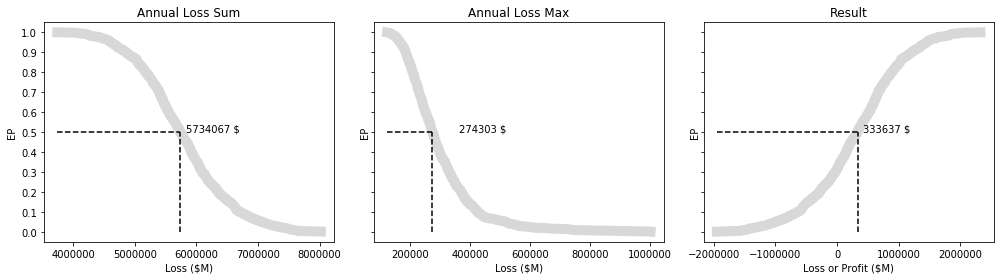

In [33]:
fig,axs = plt.subplots(1,3,figsize=(14,4),sharey=True)

for ax,lvl in zip(axs.flatten(),['loss_sum','loss_max','result']):
    ax.set_title(f"{lvl.replace('loss_','Annual Loss ').title()}")
    ax.plot(simulation[lvl]['value'],simulation[lvl]['EP'],label=lvl,linestyle='-',color='grey',lw=10,alpha=0.3)
    ax.set_xlabel('Loss ($M)')
    ax.set_ylabel('EP')
    ax.set_yticks(np.arange(0,1.1,0.1))
    
    i,j = simulation[lvl]['value'].min(),simulation[lvl].loc[simulation[lvl]['EP']==0.5,'value'].values[0]
    ax.plot([i,j],[0.5,0.5],'k--')
    ax.plot([j,j],[0,0.5],'k--')
    ax.annotate(f'{j:.0f} $',xy=(j+9e4,0.5))
axs[2].set_xlabel('Loss or Profit ($M)');
plt.tight_layout()

# Other Diagnotistics
- [Summary of diagnostics used in insurance GLM ratemaking](https://www.casact.org/education/annual/2013/handouts/Paper_2858_handout_1467_0.pdf)

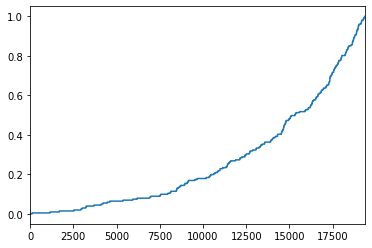

In [355]:
(r.Claim.cumsum() / r.Claim.sum()).plot();

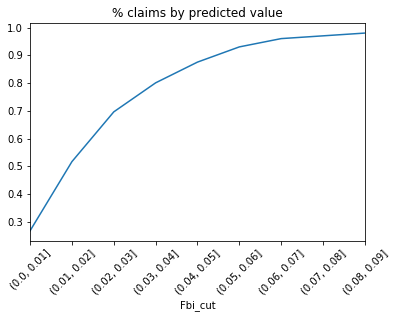

In [353]:
r = portfolio.copy()
r.sort_values(by='Fbi',ascending=True,inplace=True)
r.reset_index(drop=True,inplace=True)

r['Fbi_cut'] = pd.cut(r.Fbi,np.arange(0,0.1,0.01))
(r.groupby(['Fbi_cut']).Claim.sum().cumsum()/r.Claim.sum()).plot(rot=45)
plt.title('% claims by predicted value');

### Cumulative Gains and Lift Charts
- [Cumulative Gain](http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html)
- [Lift charts](https://www.kdnuggets.com/2016/03/lift-analysis-data-scientist-secret-weapon.html)

In [546]:
r = portfolio.copy()

# claim counts by decile of data
r['q10'] = pd.qcut(r.index,q=10,labels=np.arange(0.1,1.1,.1)).astype(float)
a = r.groupby('q10').agg(exp=('PYrs',sum),base=('Claim',sum))
a['baseline'] = a['base'].cumsum()/r.Claim.sum()
a['baserate'] = a['base'] / a['exp']
a.loc[0] = [0,0,0,0]
a.sort_index(inplace=True)
a.iloc[:2]

,exp,base,baseline,baserate
q10,,,,
0.0,0.000000,0,0.000000,0.000000
0.1,1942.367124,14,0.069652,0.007208


In [547]:
r.sort_values(by='annual_frq',ascending=False,inplace=True)
r.reset_index(drop=True,inplace=True)
r['q10'] = pd.qcut(r.index,q=10,labels=np.arange(0.1,1.1,.1)).astype(float)
r['pClaim'] = np.random.binomial(n=1,p=portfolio['annual_frq'])
                                 
b = r.groupby('q10').agg(exp=('PYrs',sum),base=('Claim',sum))
b['model'] = b['base'].cumsum()/r.Claim.sum()
b['modelrate'] = b['base'] / b['exp']
b.loc[0] = [0,0,0,0]
b.sort_index(inplace=True)
b.iloc[:2]

,exp,base,model,modelrate
q10,,,,
0.0,0.000000,0,0.000000,0.000000
0.1,3058.945181,60,0.298507,0.019615


In [548]:
c = pd.concat([a,b],axis=1)
c.reset_index(inplace=True)
c.iloc[:1]

,q10,exp,base,baseline,baserate,exp,base,model,modelrate
0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0


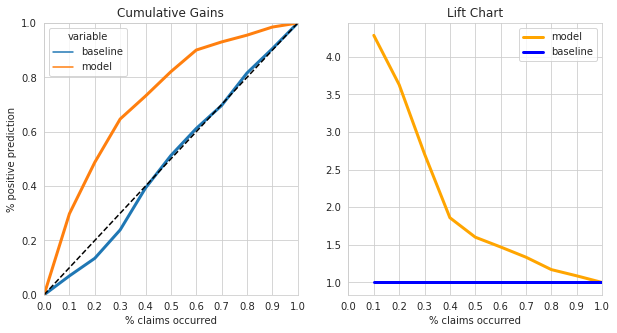

In [487]:
sns.set_style("whitegrid")
fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True)

axs[0].set_title('Cumulative Gains')
sns.lineplot(data=pd.melt(c,id_vars='q10',value_vars=['baseline','model']),
             x='q10',y='value',hue='variable',
             ax=axs[0],linewidth=3)
axs[0].plot([0,1],[0,1],'k--')
axs[0].set_xlim(0,1)
axs[0].set_ylim(0,1)
axs[0].set_ylabel('% positive prediction')

axs[1].set_title('Lift Chart')
axs[1].plot(c['q10'],c['model'] / c['baseline'],label='model',lw=3,color='orange')
axs[1].plot(c['q10'],c['baseline'] / c['baseline'],label='baseline',lw=3,color='blue')
axs[1].legend()

for ax in axs.ravel():
    ax.set_xlabel('% claims occurred')
    ax.set_xticks(c['q10'])

An alternative style to the lift plot is to:
1. Cut the dataset into deciles using the: i) background, and ii) model predicted scores (ascending ).
1. Calculate the observed response per decile. In our case Claim rate per year.
1. Plot bars to show the response rates.

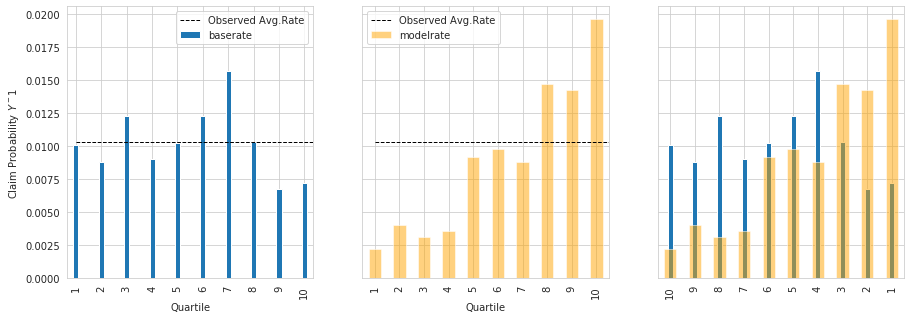

In [576]:
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)

c.iloc[1:].sort_index(ascending=False)['baserate'].plot.bar(width=0.2,
                                                            ax=axs[0]);

c.iloc[1:].sort_index(ascending=False)['modelrate'].plot.bar(alpha=0.5,
                                                             color='orange',
                                                             ax=axs[1])

c.iloc[1:].sort_index(ascending=False)['baserate'].plot.bar(width=0.2,ax=axs[2]);
c.iloc[1:].sort_index(ascending=False)['modelrate'].plot.bar(alpha=0.5,color='orange',ax=axs[2])

avg_rate = r['Claim'].sum() / r['PYrs'].sum()
for ax in axs.ravel()[:2]:
    ax.set_xticks(np.arange(0,10,1))
    ax.set_xticklabels(np.arange(1,11,1))
    ax.set_xlabel('Quartile')
    ax.plot([0,10],[avg_rate,avg_rate],'k--',lw=1,label='Observed Avg.Rate')
    ax.legend()
    ax.set_ylabel('Claim Probability $Y^-1$')

Again, we can compare the actual lift of the model per decile in relation to the Avg or Base rates by taking:

$$lift = \frac{model}{avg}$$

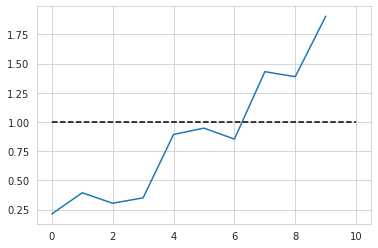

In [574]:
lift = c.iloc[1:].sort_index(ascending=False)['modelrate'].values/avg_rate
plt.plot(lift)
plt.plot([0,10],[1,1],'k--')